Importing Modules

In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Dropout, Input, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from IPython.display import clear_output

Mounting Google Drive to access Training Data

In [2]:
from google.colab import drive
drive.mount("drive")

Mounted at drive


Unzip Data

In [3]:
!unzip drive/MyDrive/Datasets/lc/FPR/FPRDataset.zip
clear_output()

In [4]:
print("Train Nodule:",len(os.listdir("FPRDataset/train/nodule")))
print("Train Non-Nodule:",len(os.listdir("FPRDataset/train/non-nodule")))
print("Test Nodule:",len(os.listdir("FPRDataset/test/nodule")))
print("Test Non-Nodule:",len(os.listdir("FPRDataset/test/non-nodule")))

Train Nodule: 5126
Train Non-Nodule: 7500
Test Nodule: 1709
Test Non-Nodule: 2500


Creating train & test data generators

In [5]:
BATCH_SIZE = 96
generator = ImageDataGenerator(rescale=1./255)
trainData = generator.flow_from_directory(
    "FPRDataset/train",
    target_size=(50,50),
    batch_size=BATCH_SIZE,
    color_mode='grayscale',
    class_mode='binary'
)
testData = generator.flow_from_directory(
    "FPRDataset/test",
    target_size=(50,50),
    batch_size=BATCH_SIZE,
    color_mode='grayscale',
    class_mode='binary'
)

Found 12626 images belonging to 2 classes.
Found 4209 images belonging to 2 classes.


In [6]:
print(trainData.class_indices)
print(testData.class_indices)

{'nodule': 0, 'non-nodule': 1}
{'nodule': 0, 'non-nodule': 1}


Callback function for training

In [7]:
weight_path="checkpoint-{epoch:03d}-{val_loss:.3f}.hdf5"
modelcheckpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True, mode='min')

Defining & creating CNN model

In [10]:
def get_model():
  input = Input(shape=(50,50,1))
  x = Conv2D(50, (3,3), activation='relu')(input)
  x = MaxPool2D((2,2))(x)
  x = Conv2D(64, (3,3), activation='relu')(x)
  x = Conv2D(64, (3,3), activation='relu')(x)
  x = MaxPool2D((2,2))(x)
  x = Flatten()(x)
  x = Dense(512, activation='relu')(x)
  x = Dropout(0.4)(x)
  x = Dense(1, activation='sigmoid')(x)

  model = Model(inputs=[input], outputs=[x])
  return model

model = get_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50, 50, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 48, 48, 50)        500       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 50)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 22, 22, 64)        28864     
                                                                 
 conv2d_2 (Conv2D)           (None, 20, 20, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 10, 10, 64)       0         
 2D)                                                         

Train model

In [11]:
with tf.device("/device:GPU:0"):
  history = model.fit_generator(
      trainData,
      epochs=20,
      validation_data=testData,
      verbose=1,
      callbacks=[modelcheckpoint]
  )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


Epoch 1/20
131/132 [============================>.] - ETA: 0s - loss: 0.5780 - accuracy: 0.7004
Epoch 00001: val_loss improved from inf to 0.47552, saving model to checkpoint-001-0.476.hdf5
132/132 [==============================] - 18s 60ms/step - loss: 0.5768 - accuracy: 0.7011 - val_loss: 0.4755 - val_accuracy: 0.7921
Epoch 2/20
132/132 [==============================] - ETA: 0s - loss: 0.4347 - accuracy: 0.8067
Epoch 00002: val_loss improved from 0.47552 to 0.36448, saving model to checkpoint-002-0.364.hdf5
132/132 [==============================] - 7s 55ms/step - loss: 0.4347 - accuracy: 0.8067 - val_loss: 0.3645 - val_accuracy: 0.8494
Epoch 3/20
132/132 [==============================] - ETA: 0s - loss: 0.3511 - accuracy: 0.8519
Epoch 00003: val_loss improved from 0.36448 to 0.34649, saving model to checkpoint-003-0.346.hdf5
132/132 [==============================] - 7s 55ms/step - loss: 0.3511 - accuracy: 0.8519 - val_loss: 0.3465 - val_accuracy: 0.8579
Epoch 4/20
132/132 [=====

Plot the history of training

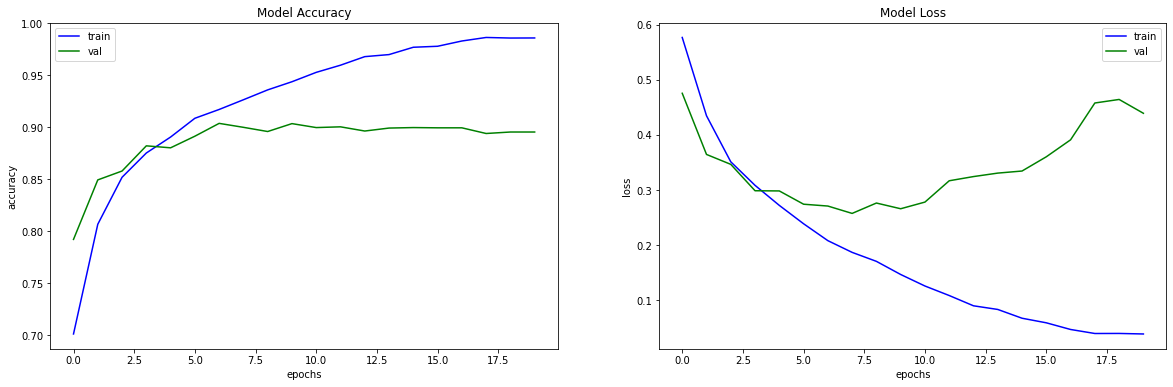

In [12]:
plt.figure(figsize=(20,6))
for i, met in enumerate(['accuracy', 'loss']):
  plt.subplot(1,2,i+1)
  plt.plot(history.history[met], color="b")
  plt.plot(history.history["val_"+met], color="g")
  plt.title('Model '+met.capitalize())
  plt.xlabel('epochs')
  plt.ylabel(met)
  plt.legend(['train', 'val'])

Save model

In [13]:
model.save("drive/MyDrive/Datasets/lc/FPR/Training_Logs/2nd_Trial/model.h5")

Load checkpoint model

In [14]:
model2 = get_model()
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model2.load_weights("checkpoint-008-0.257.hdf5")
model2.save("checkpoint_model.h5")

Copy saved model to google drive for future use

In [15]:
!cp checkpoint_model.h5 drive/MyDrive/Datasets/lc/FPR/Training_Logs/2nd_Trial/best_checkpoint_model.h5